# 构造样本

In [1]:
import collections
import random
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from gen_data import Source
from gen_data.source import Info
from gen_data.distribution import DiscreteDistribution

import utils

In [2]:
FILE_PATH = './data'
CSV_FILE = 'user.csv'

## 1. 生成源数据

Python 的 `mimesis` 包可以用来造数据。

我们来造一些用户数据，每个用户包含四个特征：名字 (FULL_NAME)、邮箱 (EMAIL)、IP (IP_V4)、UA (USER_AGENT)

In [3]:
# 生成无重复的用户特征，作为构作分布的原料
funcs = [
        Info.FULL_NAME,
        Info.EMAIL,
        Info.IP_V4,
        Info.USER_AGENT,
    ]
s = Source()
d = s.gen_features(size=3,
                   max_tries=1000,
                   funcs=funcs)
d

,full_name,email,ip_v4,user_agent
0,Tish Griffith,periodically2044@protonmail.com,20.136.162.126,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...
1,Marg Robinson,actions1839@outlook.com,240.40.187.130,Mozilla/5.0 (Windows NT 6.3) AppleWebKit/537.3...
2,Karima Jackson,monte2022@outlook.com,191.79.27.8,Mozilla/5.0 (iPhone; CPU iPhone OS 8_3 like Ma...


In [4]:
# 生成单一维度数据源
s.gen_feature(func=Info.IP_V4,
              size=5,
              max_tries=1000)

['128.208.59.54',
 '117.216.182.149',
 '104.32.55.65',
 '195.148.37.15',
 '9.119.216.165']

## 2. 生成大盘数据

### 2.1 生成正态样本分布

有原料就可以开始造数据了。

先来造大盘数据。假设大盘符合正态分布。写一个函数，构造符合正态分布的样本数据。

In [5]:
# 大盘数据
def gen_normal_samples(scale, num_samples, bins, func):
    """生成符合正态分布的样本

    :param scale: 正态分布的标准差
    :param num_samples: 样本总数
    :param bins: 分箱数，即无重复的样本数
    """

    # 生成符合正态分布的样本量
    sample_sizes = DiscreteDistribution.normal(scale=scale,
                                               num_samples=num_samples,
                                               bins=bins)

    # 生成无重复的 样本列表
    # 生成的样本量与分箱数 bins 相同
    s = Source()
    unique_sample_list = s.gen_feature(func=func,
                                       size=bins,
                                       max_tries=1000)

    # 打散 样本列表
    random.shuffle(unique_sample_list)
    samples_dict = { k:v for k, v in zip(unique_sample_list, sample_sizes) }

    return samples_dict


# 以 ipv4 为例，生成符合正态分布的 ipv4
gen_normal_samples(scale=5,
                   num_samples=30,
                   bins=10,
                   func=Info.IP_V4)

{'156.97.165.202': 5,
 '249.30.207.165': 7,
 '8.143.116.27': 4,
 '84.18.186.77': 2,
 '110.97.134.254': 6,
 '109.96.133.42': 2,
 '127.121.85.250': 0,
 '32.93.24.154': 2,
 '116.156.126.68': 0,
 '92.126.127.109': 2}

### 2.2 生成 uid 并计算访问次数

接着，我们来生成 uid。假设每个 uid 的访问次数服从泊松分布。

通过仿真，我们可以得到服从泊松分布的 uid 访问次数。

In [6]:
# 生成 uid

# 假设有 10 个人，每个人的访问次数服从泊松分布
# 泊松分布的参数 lambda = 2
uid_num = 10
poisson_lambda = 2

query_num = np.random.poisson(lam=poisson_lambda, size=uid_num)
print(f'query_num: {query_num}')

# 生成 uid 字典，key 是 uid，value 是该 uid 产生的 query 数
uid_dict = { k:v for k, v in zip(range(uid_num), query_num) if v > 0 }
print(f'uid_dict: {uid_dict}')

# 计算这 10 个人产生了多少 query
query_sum = sum(query_num)
print(f'query_sum: {query_sum}')

# 然后生成 query_sum 个 ipv4 样本
ipv4_dict = gen_normal_samples(scale=5,
                               num_samples=query_sum,
                               bins=10,
                               func=Info.IP_V4)

print(f'ipv4_dict: {ipv4_dict}')

query_num: [1 6 1 2 4 3 3 0 2 0]
uid_dict: {0: 1, 1: 6, 2: 1, 3: 2, 4: 4, 5: 3, 6: 3, 8: 2}
query_sum: 22
ipv4_dict: {'211.168.66.90': 3, '97.27.42.118': 3, '95.166.60.250': 1, '225.199.215.45': 3, '135.139.181.136': 2, '65.40.177.126': 4, '16.203.170.95': 2, '102.237.184.3': 2, '174.63.229.181': 0, '203.171.211.84': 2}


现实世界中，同一个 uid 倾向于使用同一个 ip，因此 uid 与 ip 的对应关系并非随机。

但在本次仿真中，随机组合无伤大雅。

In [7]:
# 将 uid 和 ipv4 展平后，随机混合在一起
uid_list = [ k for k, v in uid_dict.items() for _ in range(v) ]
ipv4_list = [ k for k, v in ipv4_dict.items() for _ in range(v) ]
random.shuffle(ipv4_list)

user_table = collections.defaultdict(list)
for uid, ipv4 in zip(uid_list, ipv4_list):
    user_table['uid'].append(uid)
    user_table['ipv4'].append(ipv4)

pd.DataFrame(user_table)

,uid,ipv4
0,0,16.203.170.95
1,1,65.40.177.126
2,1,135.139.181.136
3,1,225.199.215.45
4,1,97.27.42.118
5,1,65.40.177.126
6,1,211.168.66.90
7,2,225.199.215.45
8,3,211.168.66.90
9,3,225.199.215.45


通过把 uid 和 ipv4 随机地组合起来，我们得到了一张看起来像那么回事的日志表。

写一个函数，统合以上生成 `user_table` 的代码。

In [8]:
def gen_user_table(uid_num, poisson_lambda, ip_scale, ip_bins):
    query_num = np.random.poisson(lam=poisson_lambda, size=uid_num)

    # 生成 uid 字典，key 是 uid，value 是该 uid 产生的 query 数
    uid_dict = { k:v for k, v in zip(range(uid_num), query_num) if v > 0 }

    query_sum = sum(query_num)

    # 然后生成 query_sum 个 ipv4 样本
    ipv4_dict = gen_normal_samples(scale=ip_scale,
                                   num_samples=query_sum,
                                   bins=ip_bins,
                                   func=Info.IP_V4)

    # 将 uid 和 ipv4 展平后，随机混合在一起
    uid_list = [ k for k, v in uid_dict.items() for _ in range(v) ]
    ipv4_list = [ k for k, v in ipv4_dict.items() for _ in range(v) ]
    random.shuffle(ipv4_list)

    user_table = collections.defaultdict(list)
    for uid, ipv4 in zip(uid_list, ipv4_list):
        user_table['uid'].append(uid)
        user_table['ipv4'].append(ipv4)

    return pd.DataFrame(user_table)


gen_user_table(uid_num=100,
               poisson_lambda=2,
               ip_scale=0.5,
               ip_bins=80)

,uid,ipv4
0,0,124.217.67.20
1,0,140.5.88.157
2,0,112.70.243.15
3,1,112.70.243.15
4,1,248.115.245.236
...,...,...
214,98,73.103.176.92
215,98,67.49.153.216
216,99,73.103.176.92
217,99,57.125.234.224


### 2.3 时间与时间戳

为了达到运行算法的最小要求，还要给日志加上时间和时间戳。

注意了，我要整个活。假设：

1. 单位时间内，用户到达的数量服从泊松分布
2. 用户到达的最小时间粒度是 1 秒，即 1 秒内最多到达 1 个用户
3. 因为用户晚上睡觉，白天活动，所以白天的 $\lambda$ 比晚上高。可以认为 $\lambda$ 是时间 t 的函数。

构造 $\lambda$ 关于时间 $t$ 的近似函数：

$\lambda = 0.1 - \frac{1}{9 * 10^9} (t - 43200)^2 + \epsilon, t \in [0, 86400]$

其中，$\epsilon$ 是扰动项，它服从一个期望值很小的均匀分布

sum of lambda: 4432.239


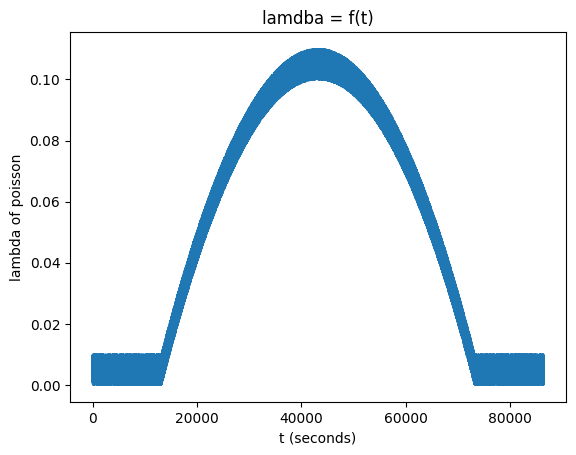

In [9]:
# 一天的总秒数
sec = 24 * 60 * 60


def lambda_func(x: list):
    y = [0.1-(e-(sec/2))**2/(9*10**9) for e in x]
    y = [0 if e < 0 else round(e, 5) for e in y]
    epsilon = np.random.uniform(low=0.0, high=0.01, size=sec)
    y = [yy+e for yy, e in zip(y, epsilon)]

    print(f'sum of lambda: {sum(y):.3f}')

    # lambda 随时间 t 变化的图像
    plt.plot(x, y)
    plt.xlabel('t (seconds)')
    plt.ylabel('lambda of poisson')
    plt.title('lamdba = f(t)')
    plt.show()

    return y, epsilon


x = range(sec)
_ = lambda_func(x)

sum of lambda: 314.094


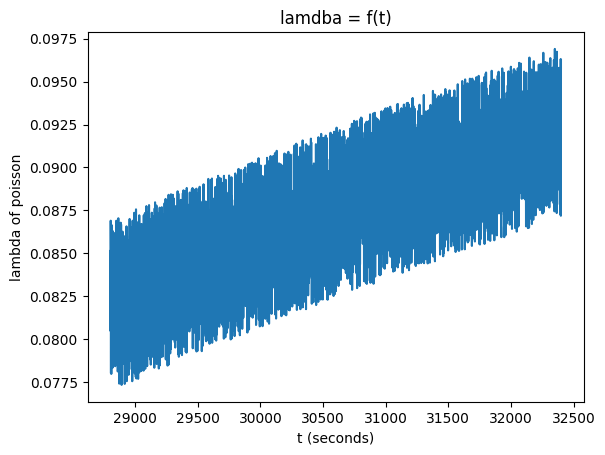

In [10]:
# 截取早上 8 点到 9 点的 lamdba 图像
# 也就是说，对于 8 点到 9 点的每一秒，我们都有一个确定的 lambda 值与之对应
x = range(8*60*60, 9*60*60)
lam, epsilon = lambda_func(x)

In [11]:
def lambda_func(x: int, epsilon):
    x = x % sec
    e = epsilon[x]
    y = 0.1-(x-(sec/2))**2/(9*10**9)
    y = 0 if y < 0 else round(y, 5)
    return y + e

In [12]:
# 从 8 点开始的第一秒算起
# 当某一秒有用户到达时，记录一下

def gen_time_list(sample_num, init_t):
    i = 0
    t = init_t
    time_list = []
    while i < sample_num:
        lam = lambda_func(t, epsilon)
        if random.random() < lam:
            # 用户到达
            i += 1
            time_list.append(t)
        t += 1

    return time_list


time_list = gen_time_list(sample_num=10,
                          init_t=8*60*60)
time_list

[28820, 28855, 28860, 28874, 28887, 28944, 28959, 28984, 28986, 29011]

In [13]:
def seconds_to_datetime(seconds):
    t = (datetime.datetime.now() + datetime.timedelta(seconds=seconds))
    return t.strftime("%Y-%m-%d %H:%M:%S"), int(t.timestamp())

[seconds_to_datetime(e) for e in time_list]

[('2024-07-31 11:38:09', 1722397089),
 ('2024-07-31 11:38:44', 1722397124),
 ('2024-07-31 11:38:49', 1722397129),
 ('2024-07-31 11:39:03', 1722397143),
 ('2024-07-31 11:39:16', 1722397156),
 ('2024-07-31 11:40:13', 1722397213),
 ('2024-07-31 11:40:28', 1722397228),
 ('2024-07-31 11:40:53', 1722397253),
 ('2024-07-31 11:40:55', 1722397255),
 ('2024-07-31 11:41:20', 1722397280)]

写一个函数，统合以上功能

In [14]:
def gen_time(sample_num, init_t):
    """生成时间与时间戳

    :param sample_num: 样本量
    :param init_t: 初始秒数
    """

    # 一天的秒数
    sec = 24 * 60 * 60

    # 一个期望值很小的均匀分布
    epsilon = np.random.uniform(low=0.0, high=0.01, size=sec)

    def lambda_func(t: int, epsilon: list, k: float = 1):
        """泊松分布的 lambda 关于时间 t 的函数
        :param t: 一天中的时间，单位是秒
        :param epsilon: 扰动项
        :param k: 放缩系数
        """
        t = t % sec
        e = epsilon[t]
        y = 0.1-(t-(sec/2))**2/(9*10**9)
        y = 0 if y < 0 else round(y, 5)
        return k * (y + e)

    def seconds_to_datetime(seconds):
        t = (datetime.datetime.now() + datetime.timedelta(seconds=seconds))
        return t.strftime("%Y-%m-%d %H:%M:%S"), int(t.timestamp())

    i = 0  # 访问次数计数
    t = init_t  # 时间计数（秒）
    time_list = []
    while i < sample_num:
        lam = lambda_func(t, epsilon, k=0.8)
        if random.random() < lam:
            # 用户到达
            i += 1
            time_list.append(t)
        t += 1

    date_dict = collections.defaultdict(list)
    for e in time_list:
        time_str, time_stamp = seconds_to_datetime(e)
        date_dict['time'].append(time_str)
        date_dict['timestamp'].append(time_stamp)

    return pd.DataFrame(date_dict)


gen_time(sample_num=200, init_t=8*60*60)

,time,timestamp
0,2024-07-31 11:37:52,1722397072
1,2024-07-31 11:37:57,1722397077
2,2024-07-31 11:38:15,1722397095
3,2024-07-31 11:38:26,1722397106
4,2024-07-31 11:38:47,1722397127
...,...,...
195,2024-07-31 12:25:51,1722399951
196,2024-07-31 12:26:22,1722399982
197,2024-07-31 12:26:42,1722400002
198,2024-07-31 12:27:09,1722400029


### 2.4 用户日志表

我们已经拥有足够的工具，来模拟生成一份用户日志表。

In [15]:
# 生成 uid 和 ip
user_table = gen_user_table(uid_num=1000,
                            poisson_lambda=2,
                            ip_scale=0.5,
                            ip_bins=800)

# 将 uid 和 ip 的 index 随机化
user_table = user_table.sample(frac=1, random_state=37).reset_index(drop=True)

# 生成 时间 和 时间戳
time_table = gen_time(sample_num=len(user_table), init_t=8*60*60)

# 将两张表 concat 起来
user_df = pd.concat([user_table, time_table], axis=1)

# 按时间戳排序
sorted_user_df = user_df.sort_values(by='timestamp', ascending=True)

sorted_user_df

,uid,ipv4,time,timestamp
0,414,0.99.111.217,2024-07-31 11:37:53,1722397073
1,402,102.242.163.20,2024-07-31 11:38:19,1722397099
2,420,198.114.211.215,2024-07-31 11:38:25,1722397105
3,85,105.159.222.43,2024-07-31 11:39:11,1722397151
4,137,79.230.162.204,2024-07-31 11:39:16,1722397156
...,...,...,...,...
2010,509,225.227.56.157,2024-07-31 18:34:02,1722422042
2011,118,46.80.254.56,2024-07-31 18:34:03,1722422043
2012,436,199.125.117.155,2024-07-31 18:34:07,1722422047
2013,173,105.178.116.45,2024-07-31 18:34:26,1722422066


把以上代码写入 `utils.py`，再用 utils 计算 `user_df`

In [16]:
user_df = utils.gen_user_df()
user_df

,uid,ipv4,time,timestamp
0,851,98.245.3.124,2024-07-31 11:37:55,1722397075
1,227,253.155.228.78,2024-07-31 11:38:18,1722397098
2,240,3.114.70.213,2024-07-31 11:38:37,1722397117
3,972,32.107.120.156,2024-07-31 11:38:52,1722397132
4,915,254.252.255.168,2024-07-31 11:39:00,1722397140
...,...,...,...,...
2002,503,118.219.88.27,2024-07-31 18:50:19,1722423019
2003,133,125.54.141.195,2024-07-31 18:50:29,1722423029
2004,425,157.168.234.253,2024-07-31 18:50:37,1722423037
2005,183,53.120.190.145,2024-07-31 18:50:42,1722423042


## 3. 生成异常数据

我们假设：

- 异常数据有固定的起停时间，攻击持续时间为 2 小时
- 异常数据使用的 ip 集有限，有 50 个无重复 ip 

### 3.1 选择攻击开始时间

In [17]:
def calc_attack_start_time(attack_duration, start_time, end_time):
    """随机选择攻击开始时间"""

    total_seconds = int((end_time - start_time).total_seconds())
    assert total_seconds > attack_duration
    total_seconds -= attack_duration
    random_seconds = random.randint(0, total_seconds)
    attack_start_time = start_time +  datetime.timedelta(seconds=random_seconds)

    return attack_start_time


# 攻击持续时间
attack_duration = 120 * 60

# 计算日志时间范围
t = [datetime.datetime.strptime(e, "%Y-%m-%d %H:%M:%S") for e in user_df['time']]
start_time = min(t)
end_time = max(t)

# 计算攻击开始时间
attack_start_time = calc_attack_start_time(attack_duration, start_time, end_time)
attack_start_time

datetime.datetime(2024, 7, 31, 15, 57, 55)

### 3.2 获取 ip 池

现实世界中，异常数据和大盘数据往往会共用一些介质。

为了模拟这种现象，从大盘 ip 中随机取 配额中 1/5 的 ip，作为异常数据 ip 池中的元素

In [18]:
def gen_ip_set(ip_num, normal_ip_list, normal_ip_rate):
    """获取 ip 池

    :param ip_num: ip 总数
    :param normal_ip_list: 大盘 ip 列表 
    :param normal_ip_rate: 坏人的 ip 池与大盘重合的比例
    """
    repeat_num = int(ip_num * normal_ip_rate)
    assert len(normal_ip_list) >= repeat_num
    ip_set = set(random.sample(normal_ip_list, repeat_num))

    # 不足的用 gen_feature 方法补足
    rest = ip_num - repeat_num
    s = Source() 
    ip_set |= set(s.gen_feature(func=Info.IP_V4,
                                size=rest,
                                max_tries=1000))

    assert len(ip_set) == ip_num

    return ip_set


ip_set = gen_ip_set(ip_num=50,
                    normal_ip_list=list(set(user_df['ipv4'])),
                    normal_ip_rate=0.2)

### 3.3 发起攻击

我们的攻击策略是：

- 使用 6 个线程
- 每次攻击从 ip 池中随机挑选一个 ip
- 单个线程的攻击间隔为 30 - 150 秒
- 每次攻击有 1/8 的概率复用“之前”使用过的uid

In [19]:
def attack(attack_duration, ip_set, min_t, max_t):
    """记录攻击 ip 和 攻击秒数"""
    t = 0
    assert max_t > min_t
    t_diff = max_t - min_t
    ip_list = list(ip_set)
    log = []
    while t < attack_duration:
        stop_time = min_t + int(t_diff * random.random())
        t += stop_time
        ip = random.sample(ip_list, 1)[0]
        log.append((ip, t))

    return log


attack(attack_duration, ip_set, min_t=30, max_t=150)

[('195.159.121.0', 55),
 ('47.156.60.142', 176),
 ('33.66.76.157', 300),
 ('113.233.29.193', 414),
 ('108.163.158.250', 459),
 ('170.118.124.203', 603),
 ('113.233.29.193', 633),
 ('212.25.125.60', 756),
 ('42.220.78.237', 879),
 ('42.220.78.237', 982),
 ('146.14.168.220', 1111),
 ('208.153.37.100', 1213),
 ('165.57.226.2', 1337),
 ('194.177.18.7', 1483),
 ('42.220.78.237', 1528),
 ('27.34.208.245', 1609),
 ('197.89.77.194', 1653),
 ('32.165.66.240', 1762),
 ('158.44.44.134', 1876),
 ('199.99.2.160', 1974),
 ('9.83.17.10', 2063),
 ('120.225.57.64', 2182),
 ('158.44.44.134', 2231),
 ('33.66.76.157', 2372),
 ('117.131.81.95', 2495),
 ('117.131.81.95', 2539),
 ('32.165.66.240', 2651),
 ('165.57.226.2', 2738),
 ('153.38.187.169', 2863),
 ('33.66.76.157', 2935),
 ('157.184.37.246', 3075),
 ('175.227.245.96', 3127),
 ('78.105.155.128', 3242),
 ('212.25.125.60', 3318),
 ('32.165.66.240', 3402),
 ('76.27.222.101', 3505),
 ('51.92.205.0', 3569),
 ('100.100.108.62', 3672),
 ('141.217.249.69', 37

In [20]:
def gen_attack_df(attack_duration, start_time, end_time, ip_num, normal_ip_list, normal_ip_rate,
                  uid_repeat_rate, min_t, max_t, epoch):
    """生成攻击日志"""
    attack_dict = collections.defaultdict(list)

    attack_start_time = calc_attack_start_time(attack_duration, start_time, end_time)

    ip_set = gen_ip_set(ip_num=ip_num,
                        normal_ip_list=normal_ip_list,
                        normal_ip_rate=normal_ip_rate)

    uid = -1
    for _ in range(epoch):
        log = attack(attack_duration, ip_set, min_t, max_t)
        for ip, attack_seconds in log:

            # uid 有 uid_repeat_rate 的概率复用之前用过的 uid
            if random.random() < uid_repeat_rate:
                uid = random.sample(range(uid, 0), 1)[0]
            else:
                uid -= 1

            attack_dict['uid'].append(uid)
            attack_dict['ipv4'].append(ip)
    
            attack_time = attack_start_time + datetime.timedelta(seconds=attack_seconds)
            attack_dict['time'].append(attack_time.strftime("%Y-%m-%d %H:%M:%S"))
            attack_dict['timestamp'].append(int(attack_time.timestamp()))

    return pd.DataFrame(attack_dict)


# 计算日志时间范围
t = [datetime.datetime.strptime(e, "%Y-%m-%d %H:%M:%S") for e in user_df['time']]

attack_df = gen_attack_df(attack_duration=120*60,
                          start_time=min(t),
                          end_time=max(t),
                          ip_num=50,
                          normal_ip_list=list(set(user_df['ipv4'])),
                          normal_ip_rate=0.2,
                          uid_repeat_rate=0.125,
                          min_t=30,
                          max_t=150,
                          epoch=6)

# attack_df

同样，我们把生成异常数据的函数写入 `utils.py`，再用它生成一次

In [21]:
# 计算日志时间范围
t = [datetime.datetime.strptime(e, "%Y-%m-%d %H:%M:%S") for e in user_df['time']]

attack_df = utils.gen_attack_df(attack_duration=120*60,
                                start_time=min(t),
                                end_time=max(t),
                                ip_num=50,
                                normal_ip_list=list(set(user_df['ipv4'])),
                                normal_ip_rate=0.2,
                                uid_repeat_rate=0.125,
                                min_t=30,
                                max_t=150,
                                epoch=6)

attack_df

,uid,ipv4,time,timestamp
0,-2,13.142.102.209,2024-07-31 12:25:42,1722399942
1,-3,221.172.224.133,2024-07-31 12:27:00,1722400020
2,-4,30.183.137.3,2024-07-31 12:29:16,1722400156
3,-5,109.198.249.119,2024-07-31 12:30:14,1722400214
4,-6,109.198.249.119,2024-07-31 12:32:05,1722400325
...,...,...,...,...
477,-3,86.251.32.14,2024-07-31 14:18:32,1722406712
478,-4,45.47.172.224,2024-07-31 14:19:12,1722406752
479,-5,30.183.137.3,2024-07-31 14:21:19,1722406879
480,-6,109.198.249.119,2024-07-31 14:22:48,1722406968


## 4. 整合两份数据

将大盘数据和异常数据 concat 起来，然后存成 csv

In [22]:
csv_path = utils.gen_abspath(directory=FILE_PATH, rel_path=CSV_FILE)
df = pd.concat([user_df, attack_df]).sort_values(by='timestamp', ascending=True)
df.to_csv(csv_path, index=False)

In [23]:
print(f'len(df): {len(df)}')
print(f'len(df[df["uid"] < 0]): {len(df[df["uid"] < 0])}')
print(f'min(df["uid"]): {min(df["uid"])}')

len(df): 2489
len(df[df["uid"] < 0]): 482
min(df["uid"]): -48


与异常捕获的难度有关的变量：

- 攻击持续的时间 `attack_duration`
- 正常 ip 的含量 `normal_ip_rate`
- 资源池的大小 `ip_num`
- 资源池的隔离 `uid_repeat_rate`
- 攻击间隔 `max_t` - `min_t`
- 攻击线程数 `epoch`